Future needs for project:
- Input try/exception into the API call to account for errors (limit exceeded, etc.)
- random date generator to get weather data for dates that weren't associated with fires
- rolling totals/avg as predictors for the following - precipitation sum (maybe 30 day rolling, percentage of days it rained multiplied by total amount), average relative humidity (weekly lag?), and adding in evapotranspiration. 

In [1]:
# imports and installs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import requests
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Functions

In [2]:
# Function for generating random dates not present in original fire dataset.
# To be used for weather data not associated with fires.

def rand_date(input_df, record_length = 1000):
    minimum_date = input_df["date"].min() # Initializing range of dates associated with df
    maximum_date = input_df["date"].max()

    listed_date = [minimum_date] # Initializing list of dates with minimum
    new_dates = []

    while minimum_date != maximum_date: # All dates not associated with fires 
        minimum_date += timedelta(days=1)
        if minimum_date in input_df["date"]:
            pass
        else:
            listed_date.append(minimum_date)

    for i in range(record_length): # Random generation of dates not associated with fire
        rand_num = np.random.randint(0, len(listed_date))
        curr_date = listed_date[rand_num]
        new_dates.append(curr_date)

    return pd.Series(new_dates)

## Gathering Data - Historical and API

In [3]:
# Reading in random samples from historical data of a given length.
record_length = 2000
directory = "/Users/coleparker/Documents/Udemy/Personal Challenges/Fire_Prediction/"
file_name = "Fire_Occurrence_Data_2000_2022.csv"

# Reading in fire data and dropping unnecessary columns for analysis
df_fire_full = pd.read_csv(directory + file_name)
df_fire_cleaned = df_fire_full.drop(     
    [
        "Serial",
        "FireCategory",
        "Area",
        "DistrictName",
        "UnitName",
        "FullFireNumber",
        "Cause_Comments",
        "LatLongDD",
        "FO_LandOwnType",
        "Twn",
        "Rng",
        "Sec",
        "Subdiv",
        "LandmarkLocation",
        "County",
        "RegUseZone",
        "RegUseRestriction",
        "Industrial_Restriction",
        "DistrictCode",
        "UnitCode",
        "DistFireNumber",
    ],
    axis=1,
)

# Pulling in most recent 700 observations 
df_fire_cleaned.sort_values(["ReportDateTime"], inplace=True, ascending=False)
df_fire_cleaned = df_fire_cleaned.sample(n=record_length)

# Dropping any null rows
df_fire_cleaned = df_fire_cleaned.dropna()

# Converting datetime columns to appropriate datatype
df_fire_cleaned["Ign_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Ign_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)
df_fire_cleaned["Control_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Control_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)

# Invalid data where the controlled datetime occured before the ignite datetime. 
df_fire_cleaned = df_fire_cleaned.drop(
    df_fire_cleaned.index[
        df_fire_cleaned["Control_DateTime"] < df_fire_cleaned["Ign_DateTime"]
    ].tolist()
)

### API Call

The below cell is retrieving weather data associated with the historical fire data and also pulling weather data for dates which are NOT present in the historical fire data. 

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=5)
openmeteo = openmeteo_requests.Client(session=retry_session)

hourly_dataframe_agg = pd.DataFrame()
daily_dataframe_agg = pd.DataFrame()

# try:
for point in tqdm(range(len(df_fire_cleaned))):
    lat_current = df_fire_cleaned["Lat_DD"].iloc[point]
    long_current = df_fire_cleaned["Long_DD"].iloc[point]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "end_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure", "dew_point_2m",
                   "apparent_temperature", "precipitation"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration", "temperature_2m_max", "temperature_2m_min"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Retrieve hourly data from API. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    # Initializing dictionary with appropriate dates for hourly interval data
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(hour=23, minute=59, second=59),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[:len(hourly_data['date'])]
    hourly_data["surface_pressure"] = hourly_surface_pressure[:len(hourly_data['date'])]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[:len(hourly_data['date'])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[:len(hourly_data['date'])]
    hourly_data["precipitation"] = hourly_precipitation[:len(hourly_data['date'])]

    # Resizing the daily fire data by duplicating entries based on number of hourly observations
    hourly_dataframe = pd.DataFrame(data=hourly_data)
    df_fire_cleaned_repeat_hour = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(hourly_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )

    # Combining the hourly weather data with the duplicated fire entries
    hourly_dataframe = pd.concat([hourly_dataframe, df_fire_cleaned_repeat_hour], axis=1)
    hourly_dataframe_agg = pd.concat(
        [hourly_dataframe_agg, hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit = "s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    daily_dataframe = pd.DataFrame(data=daily_data)
    df_fire_cleaned_repeat_day = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(daily_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )
    daily_dataframe = pd.concat([daily_dataframe, df_fire_cleaned_repeat_day], axis=1)
    daily_dataframe_agg = pd.concat(
        [daily_dataframe_agg, daily_dataframe], ignore_index=True, axis=0
    )
# except:
# print("API limit reached - retry later")

generated_dates = rand_date(daily_dataframe_agg, 2000)
extra_hourly_dataframe_agg = pd.DataFrame()
extra_daily_dataframe_agg = pd.DataFrame()

# try:
for point in tqdm(range(len(generated_dates))):
    lat_long_modulo = point % len(df_fire_cleaned)
    lat_current = df_fire_cleaned["Lat_DD"].iloc[lat_long_modulo]
    long_current = df_fire_cleaned["Long_DD"].iloc[lat_long_modulo]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "end_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure", "dew_point_2m",
                   "apparent_temperature", "precipitation"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration", "temperature_2m_max", "temperature_2m_min"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.Time(), unit="s", utc=True).replace(hour=23, minute=59, second=59),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm[:len(hourly_data['date'])]
    hourly_data["surface_pressure"] = hourly_surface_pressure[:len(hourly_data['date'])]
    hourly_data["dew_point_2m"] = hourly_dew_point_2m[:len(hourly_data['date'])]
    hourly_data["apparent_temperature"] = hourly_apparent_temperature[:len(hourly_data['date'])]
    hourly_data["precipitation"] = hourly_precipitation[:len(hourly_data['date'])]

    extra_hourly_dataframe = pd.DataFrame(data=hourly_data)
    extra_hourly_dataframe_agg = pd.concat(
        [extra_hourly_dataframe_agg, extra_hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min

    extra_daily_dataframe = pd.DataFrame(data=daily_data)
    extra_daily_dataframe_agg = pd.concat(
        [extra_daily_dataframe_agg, extra_daily_dataframe], ignore_index=True, axis=0
    )
# except:
# print("API limit reached - retry later")

hourly_dataframe_agg = pd.concat(
    [hourly_dataframe_agg, extra_hourly_dataframe_agg], ignore_index=True, axis=0
)
daily_dataframe_agg = pd.concat(
    [daily_dataframe_agg, extra_daily_dataframe_agg], ignore_index=True, axis=0
)

100%|██████████| 2000/2000 [06:54<00:00,  4.83it/s]


## Conversions and Cleanup

In [5]:
# Replacing size class with numeric values
size_class_dict = {"A": 1, "B": 1, "C": 1, "D": 1, "E": 1, "F": 1}
daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].map(
    size_class_dict
)
hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].map(
    size_class_dict
)

# Converting to numeric
daily_dataframe_agg["EstTotalAcres"] = pd.to_numeric(
    daily_dataframe_agg["EstTotalAcres"]
)
hourly_dataframe_agg["EstTotalAcres"] = pd.to_numeric(
    hourly_dataframe_agg["EstTotalAcres"]
)

# Converting to UTC datetime
daily_dataframe_agg["date"] = daily_dataframe_agg["date"].dt.tz_convert("UTC")
daily_dataframe_agg["Ign_DateTime"] = daily_dataframe_agg["Ign_DateTime"].dt.tz_localize("UTC")
daily_dataframe_agg["ReportDateTime"] = pd.to_datetime(daily_dataframe_agg["ReportDateTime"]).dt.tz_localize("UTC")
daily_dataframe_agg["Discover_DateTime"] = pd.to_datetime(daily_dataframe_agg["Discover_DateTime"]).dt.tz_localize("UTC")
daily_dataframe_agg["Control_DateTime"] = daily_dataframe_agg["Control_DateTime"].dt.tz_localize("UTC")
daily_dataframe_agg["CreationDate"] = pd.to_datetime(daily_dataframe_agg["CreationDate"]).dt.tz_localize("UTC")
daily_dataframe_agg["ModifiedDate"] = pd.to_datetime(daily_dataframe_agg["ModifiedDate"]).dt.tz_localize("UTC")
hourly_dataframe_agg["date"] = hourly_dataframe_agg["date"].dt.tz_convert("UTC")
hourly_dataframe_agg["Ign_DateTime"] = hourly_dataframe_agg["Ign_DateTime"].dt.tz_localize("UTC")
hourly_dataframe_agg["ReportDateTime"] = pd.to_datetime(hourly_dataframe_agg["ReportDateTime"]).dt.tz_localize("UTC")
hourly_dataframe_agg["Discover_DateTime"] = pd.to_datetime(hourly_dataframe_agg["Discover_DateTime"]).dt.tz_localize("UTC")
hourly_dataframe_agg["Control_DateTime"] = hourly_dataframe_agg["Control_DateTime"].dt.tz_localize("UTC")
hourly_dataframe_agg["CreationDate"] = pd.to_datetime(hourly_dataframe_agg["CreationDate"]).dt.tz_localize("UTC")
hourly_dataframe_agg["ModifiedDate"] = pd.to_datetime(hourly_dataframe_agg["ModifiedDate"]).dt.tz_localize("UTC")

/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_47443/3413723842.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg["ReportDateTime"] = pd.to_datetime(daily_dataframe_agg["ReportDateTime"]).dt.tz_localize("UTC")
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_47443/3413723842.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg["Discover_DateTime"] = pd.to_datetime(daily_dataframe_agg["Discover_DateTime"]).dt.tz_localize("UTC")
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_47443/3413723842.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent

In [6]:
# Aggregating the hourly data to the daily level with mean so it can
# be combined with the daily dataframe. 

hourly_dataframe_agg['day'] = hourly_dataframe_agg['date'].dt.date
hourly_dataframe_agg.drop(
    [
        "FireYear"
        , "FireName"
        , "EstTotalAcres"
        , 'Protected_Acres'
        , 'HumanOrLightning'
        ,'CauseBy'
        , 'GeneralCause'
        , 'SpecificCause'
        , 'Lat_DD'
        , 'Long_DD'
        , 'Ign_DateTime'
        , 'ReportDateTime'
        , 'Discover_DateTime'
        , 'Control_DateTime'
        , 'CreationDate'
        , 'ModifiedDate'
        , 'date'
    ],
    axis=1,
    inplace=True,
)

hourly_dataframe_agg["Size_class"] = hourly_dataframe_agg["Size_class"].fillna(value=0.0)

daily_addhourly_dataframe_agg = hourly_dataframe_agg.groupby(
    [
        "day"
        , "Size_class"
    ],
    as_index=False,
).mean()

daily_dataframe_agg['day'] = daily_dataframe_agg['date'].dt.date
daily_dataframe_agg.drop(
    [
        "FireYear"
        , "FireName"
        , "EstTotalAcres"
        , 'Protected_Acres'
        , 'HumanOrLightning'
        ,'CauseBy'
        , 'GeneralCause'
        , 'SpecificCause'
        , 'Lat_DD'
        , 'Long_DD'
        , 'Ign_DateTime'
        , 'ReportDateTime'
        , 'Discover_DateTime'
        , 'Control_DateTime'
        , 'CreationDate'
        , 'ModifiedDate'
        , 'date'
    ],
    axis=1,
    inplace=True,
)

daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].fillna(value=0.0)

daily_dataframe_merged = daily_dataframe_agg.merge(
    daily_addhourly_dataframe_agg, on=["day", "Size_class"], how="left"
)

## Visualizing Features

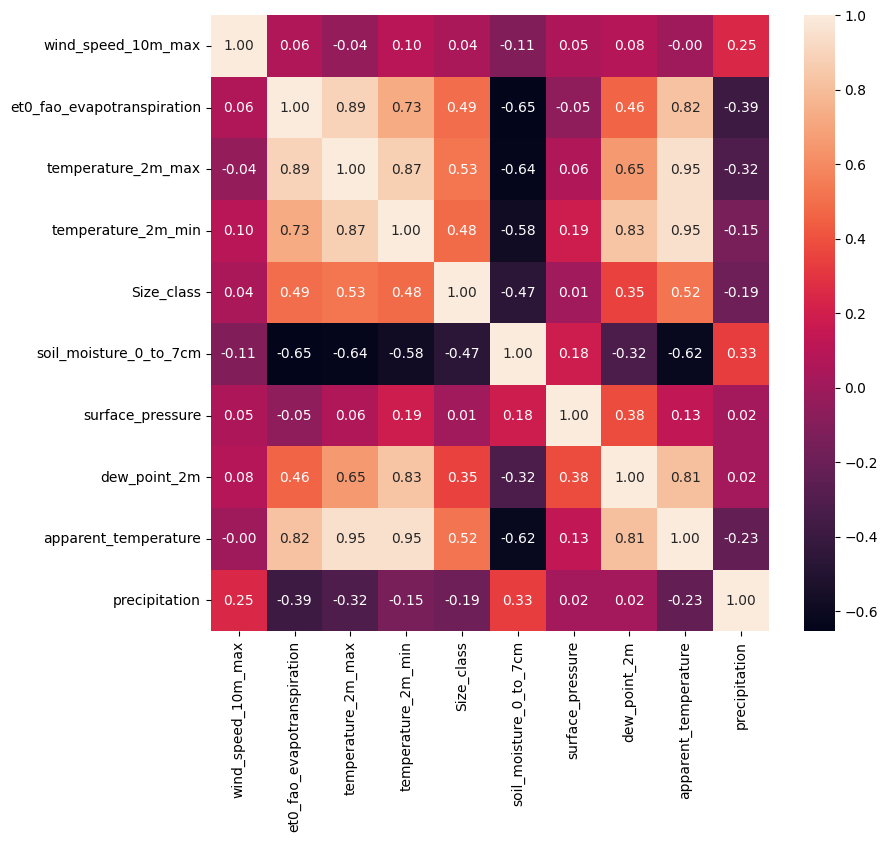

In [7]:
# Visualization to compare size class correlations with numeric variables
plt.figure(figsize=(9, 8))
sns.heatmap(daily_dataframe_merged.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Training & Model Evaluation

Based on the below GridSearch, the best parameters were as follows: {'C': 1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}

{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}

In [8]:
# Initializing and training an ensemble model for classification. Precision & 
# Recall used to identify performance instead of pure accuracy. 

pd_X = daily_dataframe_merged.drop(["Size_class", "day"], axis=1)
pd_y = daily_dataframe_merged["Size_class"]
X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.2)

# GridSearch to optimize hyperparameters based on the f1 score
param_grid_RFC = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None],
    'max_features': [1, 3, 5, 7],
    'min_samples_leaf':[1, 2, 3],
    'min_samples_split':[2, 3]
}

RFC = RandomForestClassifier()

grid_RFC = GridSearchCV(estimator = RFC, param_grid=param_grid_RFC, verbose = 0, cv = 3, n_jobs=-1, scoring='f1_micro')
grid_RFC.fit(X_train, y_train)
grid_pred = grid_RFC.predict(X_test)

print('The classification report below:')
print(classification_report(y_test, grid_pred), flush = True)
print('\n')
print('The best parameters for the GridSearch:')
print(grid_RFC.best_params_, flush = True)

The classification report below:
              precision    recall  f1-score   support

         0.0       0.78      0.68      0.73       407
         1.0       0.70      0.80      0.75       387

    accuracy                           0.74       794
   macro avg       0.74      0.74      0.74       794
weighted avg       0.74      0.74      0.74       794



The best parameters for the GridSearch:
{'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## New Data Prediction

For context to choose test variables for prediction probabilities, reference the below distribution of features

In [9]:
daily_dataframe_merged.describe().drop(['Size_class'], axis = 1)

,wind_speed_10m_max,et0_fao_evapotranspiration,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm,surface_pressure,dew_point_2m,apparent_temperature,precipitation
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000
mean,8.423561,0.140468,68.029198,46.433659,0.272821,942.013000,41.823254,52.707825,0.003011
std,3.174526,0.079308,17.039097,11.890268,0.113948,49.396736,9.846601,15.672190,0.008913
min,1.500625,0.004021,15.575901,-6.858398,0.021294,803.768005,-2.456182,-1.690215,0.000000
25%,6.327191,0.065622,54.786201,37.991299,0.177176,901.518127,36.044785,40.734825,0.000000
50%,8.009584,0.144478,68.909897,48.606800,0.258235,949.909790,43.838680,55.281868,0.000000
75%,9.875792,0.208560,81.875298,55.526001,0.368353,982.538574,49.117683,65.323830,0.001158
max,35.178558,0.395277,110.959694,74.396301,0.510000,1030.606567,63.420086,87.953735,0.113478


In [39]:
# Make feature declarations to test model prediction probabilities - the below
# selections are based on a 'best case' scenario, where weather conditions are
# not favorable to a fire

var_wind_speed = 5
var_evapotranspiration = 0.05
var_temperature_max = 50
var_temperature_min = 20
var_soil_moisture = 0.5
var_surface_pressure = 810
var_dew_point = 30
var_apparent_temperature = 30
var_precipitation = 0.005

# Creating a dataframe to pass to the model
new_weather_data = pd.DataFrame(data = [[var_evapotranspiration
                                         , var_evapotranspiration
                                         , var_temperature_max
                                         , var_temperature_min
                                         , var_soil_moisture
                                         , var_surface_pressure
                                         , var_dew_point
                                         , var_apparent_temperature
                                         , var_precipitation]]
                                , columns = X_test.columns)

print(f"The models predicted probability of a fire starting (class {int(grid_RFC.classes_[1])}) with the given values: "
      , round(grid_RFC.predict_proba(new_weather_data)[0][1] * 100, 2)
      , '%')

The models predicted probability of a fire starting (class 1) with the given values:  8.67 %
